In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install mtcnn

In [ ]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [ ]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import numpy as np


In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

 # load images and extract faces for all images in a directory
def load_faces(directory):
  faces = list()
	# enumerate files
  for filename in listdir(directory):
		# path
    path = directory + filename
		# get face
    face = extract_face(path)
		# store
    faces.append(face)
  return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
  X, y = list(), list()
	# enumerate folders, on per class
  for subdir in listdir(directory):
    # path
    path = directory + subdir + '/'
    
		# skip any files that might be in the dir
    if not isdir(path):
      continue
		# load all faces in the subdirectory
    faces = load_faces(path)
		# create labels
    labels = [subdir for _ in range(len(faces))]
		# summarize progress
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
    X.extend(faces)
    y.extend(labels)
  return asarray(X), asarray(y)

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)


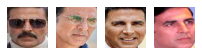

In [ ]:
folder='/content/gdrive/MyDrive/ACS_dataset/Train/Akshay_Kumar/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

In [ ]:
# load train dataset
trainX, trainy = load_dataset('/content/gdrive/MyDrive/ACS_dataset/Train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/gdrive/MyDrive/ACS_dataset/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 5 examples for class: norman_freeman
>loaded 5 examples for class: terry_crews
>loaded 5 examples for class: Nidhi
>loaded 5 examples for class: will_smith
>loaded 5 examples for class: drake
>loaded 5 examples for class: millie_brown
>loaded 5 examples for class: niall_horan
>loaded 5 examples for class: michelle_obama
>loaded 5 examples for class: kim_kadarshian
>loaded 5 examples for class: david_shwimmer
>loaded 5 examples for class: ellen
>loaded 4 examples for class: Akshay_Kumar
>loaded 0 examples for class: .ipynb_checkpoints
>loaded 5 examples for class: Alia_Bhatt
>loaded 5 examples for class: Anushka_sharma
>loaded 5 examples for class: Julia_Michaels
>loaded 5 examples for class: Pankaj_kapoor
>loaded 5 examples for class: Radhika_apte
>loaded 5 examples for class: Sonam_kapoor
>loaded 5 examples for class: Suneel_sinhapadman
>loaded 5 examples for class: kareena_Kapoor
>loaded 5 examples for class: priyanka_chopra
(104, 160, 160, 3) (104,)
>loaded 3 examples for cl

In [ ]:
print(trainy)

['norman_freeman' 'norman_freeman' 'norman_freeman' 'norman_freeman'
 'norman_freeman' 'terry_crews' 'terry_crews' 'terry_crews' 'terry_crews'
 'terry_crews' 'Nidhi' 'Nidhi' 'Nidhi' 'Nidhi' 'Nidhi' 'will_smith'
 'will_smith' 'will_smith' 'will_smith' 'will_smith' 'drake' 'drake'
 'drake' 'drake' 'drake' 'millie_brown' 'millie_brown' 'millie_brown'
 'millie_brown' 'millie_brown' 'niall_horan' 'niall_horan' 'niall_horan'
 'niall_horan' 'niall_horan' 'michelle_obama' 'michelle_obama'
 'michelle_obama' 'michelle_obama' 'michelle_obama' 'kim_kadarshian'
 'kim_kadarshian' 'kim_kadarshian' 'kim_kadarshian' 'kim_kadarshian'
 'david_shwimmer' 'david_shwimmer' 'david_shwimmer' 'david_shwimmer'
 'david_shwimmer' 'ellen' 'ellen' 'ellen' 'ellen' 'ellen' 'Akshay_Kumar'
 'Akshay_Kumar' 'Akshay_Kumar' 'Akshay_Kumar' 'Alia_Bhatt' 'Alia_Bhatt'
 'Alia_Bhatt' 'Alia_Bhatt' 'Alia_Bhatt' 'Anushka_sharma' 'Anushka_sharma'
 'Anushka_sharma' 'Anushka_sharma' 'Anushka_sharma' 'Julia_Michaels'
 'Julia_Michaels' '

In [ ]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (104, 160, 160, 3) (104,) (63, 160, 160, 3) (63,)


In [ ]:
model = load_model('/content/gdrive/MyDrive/keras-facenet/model/facenet_keras.h5')
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [ ]:
# convert each face in the train set to an embedding
emb_TrainX = list()
for face_pixels in trainX:
  embedding = get_embedding(model,face_pixels)
  emb_TrainX.append(embedding)
emb_TrainX = asarray(emb_TrainX)
print(emb_TrainX.shape)
# convert each face in the test set to an embedding
emb_TestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	emb_TestX.append(embedding)
emb_TestX = asarray(emb_TestX)
print(emb_TestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', emb_TrainX, trainy, emb_TestX, testy)

Cause: could not parse the source code of <function <lambda> at 0x7f708c71f440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f708c71f440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f708c71fcb0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f708c71fcb0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f708c71f950>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could no

In [ ]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=104, test=63


In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
classifier = SVC(kernel='linear', probability=True)
classifier.fit(trainX, trainy)
# predict
yhat_train = classifier.predict(trainX)
yhat_test = classifier.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))


Accuracy: train=100.000, test=100.000


In [ ]:
import sklearn

print(sklearn.__version__)

0.22.2.post1


In [ ]:
import os
import pickle
with open('out_encoder.pkl','wb') as fout:
  pickle.dump(out_encoder,fout)

In [ ]:
print(trainy)

[17 17 17 17 17 19 19 19 19 19  4  4  4  4  4 20 20 20 20 20 10 10 10 10
 10 15 15 15 15 15 16 16 16 16 16 14 14 14 14 14 13 13 13 13 13  9  9  9
  9  9 11 11 11 11 11  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3
  3  3  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8 12 12
 12 12 12 18 18 18 18 18]


In [ ]:

with open('best_model3.pkl','wb') as fout:
  pickle.dump(classifier,fout)

In [ ]:
with open("/content/best_model2.pkl", 'rb') as file:
        model = pickle.load(file)
print("Custom Classifier, Successfully loaded")

Custom Classifier, Successfully loaded


In [ ]:
# test model on a random example from the internet

random_face_pixels = extract_face('/content/jmtest.jpg')
print(random_face_pixels.shape)
random_face_emb = get_embedding(model,random_face_pixels)
print(random_face_emb.shape)


(160, 160, 3)
(128,)


[[2.49947784e-14 6.49376497e-14 8.03818061e-14 9.99999571e-01
  6.26713790e-09 7.59163003e-09 1.87841758e-08 1.92920079e-07
  1.72718490e-08 8.22040381e-09 1.10628523e-08 6.29517298e-09
  1.84492328e-08 1.46661213e-08 5.13613888e-09 7.88949781e-09
  6.08892592e-09 7.83996726e-09 6.39714224e-08 2.29834369e-08
  1.36717433e-08]]
Predicted: Julia_Michaels (100.000)
Expected: julia_michaels


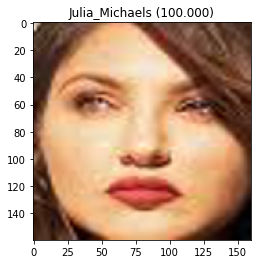

In [ ]:
random_face_name = 'julia_michaels'
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = classifier.predict(samples)
yhat_prob =  classifier.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name)
# plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
# test model on a random example from the internet

random_face_pixels = extract_face('/content/aktest.jpg')
print(random_face_pixels.shape)
random_face_emb = get_embedding(model,random_face_pixels)
print(random_face_emb.shape)

(160, 160, 3)
(128,)


Predicted: Akshay_Kumar (50.064)
Expected: akshay_kumar


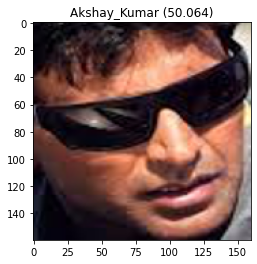

In [ ]:
random_face_name = 'akshay_kumar'
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = classifier.predict(samples)
yhat_prob =  classifier.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name)
# plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
# test model on a random example from the internet

random_face_pixels = extract_face('/content/pktest.jpg')
print(random_face_pixels.shape)
random_face_emb = get_embedding(model,random_face_pixels)
print(random_face_emb.shape)

(160, 160, 3)
(128,)


Predicted: Pankaj_kapoor (98.551)
Expected: pankaj_kapoor


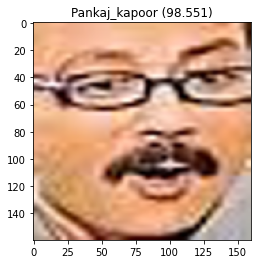

In [ ]:
random_face_name = 'pankaj_kapoor'
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = classifier.predict(samples)
yhat_prob =  classifier.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
if class_probability<95:
  predict_names='unknown'
else:
  predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name)
# plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

Predicted: Anushka_sharma (98.218)
Expected: unknown


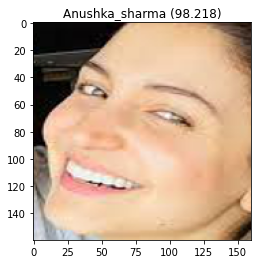

In [ ]:
random_face_pixels = extract_face('/content/astest.jpg')
random_face_emb = get_embedding(model,random_face_pixels)
random_face_name = 'unknown'
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = classifier.predict(samples)
yhat_prob =  classifier.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
if class_probability<95:
  predict_names='unknown'
else:
  predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name)
# plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()